# Matching Code

This code is to implement and test different matching methods

Explain why we did matching? plot average distances of matching. Think of a KPI. Illustrate with one graph or visualisation, this can be a good distance measure, then back up with literature, the ECB article.

Comapre the coverage, do we have more bonds than taking a very strict matching algorithm, Create a table with different matching algorithms and the results. Show that we used different matching methods.

emphasise that the data is scarce, we do not want to lose too much data, get better results with broader scope. 

for any given green bond, take the match which has the smallest distance
take average distance. group by bonds and conventional bond unique name, compute mean average distance.
then take smallest pair in average.

weight the coupon in the distance measure a bit less, put more weight on the days to maturity.
include emission date measure. 

Show this in our analysis.

test YTM vs. Z-spread.

• Aggregate bonds by ISIN per company (since each bond appears over multiple dates) so that matching is done at the bond‐level rather than per DateTime row.
• Compute a custom distance using three features (Coupon, days‐to‐maturity, and an emission year extracted from your emission columns). We then down‐weight Coupon (here by a factor of 0.5) so that differences in days‐to‐maturity and emission year matter more.
• Perform one‐to‐one matching by solving a bipartite assignment (using the Hungarian algorithm via SciPy’s linear_sum_assignment) so that each green bond is matched with one conventional bond (and vice‐versa as far as possible).
• After matching, we merge the matched bond pairs back with the original time‐series data (using DateTime) to compute the YTM difference (green minus conventional) on the dates where both bonds are observed.
• Finally, we run a regression of the YTM difference on the matching “distance” as an example. (You could, of course, include additional controls or test against the Z‑spread if available.)
• A bar chart is produced as a key performance indicator (KPI) visualization of average matching distance per company. This type of plot can serve as a “good distance measure” and can be compared with similar measures in the literature (for example, see the ECB article on matching methods).

Why Matching?
 Matching green bonds with conventional ones allows us to form comparable pairs so that differences in yield‐to‐maturity (YTM) can be more reliably attributed to “green” factors rather than differences in bond characteristics. A good distance measure (here the Euclidean distance between standardized features) helps ensure that the matched pairs are similar. Researchers (see, for example, ECB publications) have used similar approaches to control for confounding variables.

Visualization (KPI):
 The bar chart of average matching distance per company provides an intuitive measure of how “close” the pairs are. A lower average distance indicates better matches. This can be used as a key performance indicator when comparing different matching methods.

Coverage vs. Stringency:
 By comparing the number of matches and average distances across methods (as illustrated in the optional summary table), one can demonstrate that while stricter matching may yield a lower average distance (better quality), it might also lead to a smaller sample. In our context—where data are scarce—a broader matching criterion (one-to-one matching as shown) may be preferable.

Regression Analysis:
 After matching, the code merges the time series data so that for each bond pair we have YTM observations over time. The regression of the YTM difference on the matching distance (and any other covariates you may add) tests whether the “quality” of the match relates to the observed YTM spread. You could extend this analysis to test against the Z‑spread as well.

Stacked Panel Regression:
The new function prepare_stacked_regression_data creates a dataset where each time-series observation from the green and conventional bonds is kept (with an indicator is_green and other characteristics such as Coupon and maturity). We then run a panel regression (using clustered standard errors by bond pair) to see if, after controlling for these factors, there is a significant difference in YTM between green and conventional bonds.

# Cleaned Code

# 1 - Imports & Cleaning

In [31]:
# Import with correcting the dataset parsing
import pandas as pd
import numpy as np

def parse_numeric(value):
    """
    Convert a string like '3,08%', '3.08', '3,08', '3.1%' to a float.
    Removes trailing '%' if present, replaces commas with dots,
    and attempts float conversion. Returns NaN on failure.
    """
    if pd.isna(value):
        return np.nan
    # Convert to string in case it is not
    value_str = str(value).strip()
    # Remove percentage sign if present
    value_str = value_str.replace('%', '')
    # Replace commas with dots
    value_str = value_str.replace(',', '.')
    # Attempt to convert to float
    try:
        return float(value_str)
    except ValueError:
        return np.nan

# Read your CSV file
url = "https://raw.githubusercontent.com/Fijiman001/EGR-Empirical-Project/refs/heads/main/data/Final%20data%20for%20the%20study/df_final_7.csv"
df = pd.read_csv(url)

# Now parse the columns of interest. For example, if you have columns:
# 'YTM', 'Coupon', 'Modified Duration', etc.
df['YTM'] = df['YTM'].apply(parse_numeric)
df['Coupon'] = df['Coupon'].apply(parse_numeric)
df['Modified Duration'] = df['Modified Duration'].apply(parse_numeric) / 1000

# Now df['YTM'], df['Coupon'], and df['Modified Duration'] will be numeric.
print(df[['YTM','Coupon','Modified Duration']].head(10))

    YTM  Coupon  Modified Duration
0  2.46   0.375              2.405
1  2.50   0.375              2.405
2  2.47   0.375              2.405
3  2.51   0.375              2.405
4  2.55   0.375              2.405
5  2.52   0.375              2.405
6  2.57   0.375              2.405
7  2.53   0.375              2.405
8  2.52   0.375              2.405
9  2.55   0.375              2.405


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Optional: Configure matplotlib for inline plotting
%matplotlib inline

In [33]:
print(df.columns)

# The amount of companies with more than 1 unique ISIN
companies = df.groupby('Company')['ISIN'].nunique()
companies = companies[companies > 1]
print(companies)

# Companies with both 1 green and one conventional bond, 'is_green needs to be both 0 and 1
companies = df.groupby('Company')['is_green'].nunique()
companies = companies[companies == 2]
print(companies)

# of those companies, we look at the amount of bonds available
matching_companies = {}
for company in companies.index:
    group = df[df['Company'] == company]
    matched = group['ISIN'].nunique()
    print(f"{company}: {matched} unique ISINs")
    matching_companies[company] = matched
print("list of issuers with both green and conventional bonds we will be analysing")
print(list(matching_companies.keys()))

Index(['Name', 'Clean_Company_Maturity', 'WKN', 'URL', 'ISIN', 'Company',
       'Kupon_Maturity', 'Coupon', 'Maturity_Start', 'Maturity_End',
       'is_green', 'Last Price', 'DateTime', 'Volume in Euro', '+/- %',
       'Currency', 'YTM', 'Modified Duration', 'Kupon', 'Emittent', 'Branche',
       'Fälligkeit', 'Schuldnerkündigungsart', 'Sonderkündigung', 'Nachrangig',
       'Kleinste handelbare Einheit', 'Spezialist', 'Handelsmodell',
       'Emissionsdatum', 'Emissionsvolumen', 'Umlaufendes Volumen',
       'Emissionswährung', 'Depotwährung', 'Notierungsaufnahme',
       'Emission_year_2020.0', 'Emission_year_2021.0', 'Emission_year_2022.0',
       'Emission_year_2023.0', 'Emission_year_2024.0', 'Emission_year_2025.0',
       'Date', 'fälligkeit_datum', 'emission_datum', 'days_to_maturity'],
      dtype='object')
Company
a2a s p a                                3
ab svensk exportkredit                   2
acea s p a                               2
amprion gmbh                     

we keep firms that have both a green and conventional bond in the data set, we will be using those to create a subset of the data that we will be using to run our analysis on

In [34]:
df_for_matching = df[df['Company'].isin(matching_companies.keys())]
# Dimensions of df_for_matching, the amount of unique ISINs, and the amount of Companies
print(df_for_matching.shape)
print(df_for_matching['ISIN'].nunique())
print(df_for_matching['Company'].nunique())
# amount of bonds that are green
print(df_for_matching[df_for_matching['is_green'] == 1]['ISIN'].nunique())

(6588, 44)
288
35
100


the matched data set only has 6588 rows, with 288 unique ISINS and 35 unique emitters. of those 288 bonds, 100 bonds are green
given this subset of data, we create our distance measure to find the closest comparable bonds to the green bonds

In [35]:
# Overview of the currencies used in the dataset
df_for_matching['Emissionswährung'].unique()
for currency in df_for_matching['Emissionswährung'].unique():
    print(currency)
    print(df[df['Emissionswährung'] == currency]['ISIN'].nunique())

EUR
370
USD
27
CAD
3
BRL
2
COP
1
GBP
5
NZD
1
NOK
1
HUF
1
ZAR
1
AUD
2
TRY
1


we will only keep EUR bonds

In [36]:
# keeping only EUR
df_for_matching = df_for_matching[df_for_matching['Emissionswährung'] == 'EUR']
print(df_for_matching.shape)

(5948, 44)


In [37]:
print(df_for_matching['is_green'].value_counts())
print(df_for_matching['Company'].nunique())
print(df_for_matching['ISIN'].nunique())
print(df_for_matching[df_for_matching['is_green']==1]['ISIN'].nunique())

is_green
1    4349
0    1599
Name: count, dtype: int64
34
260
93


In [38]:
# Sorting the data by date
df_for_matching['DateTime'] = pd.to_datetime(df_for_matching['DateTime'], errors='coerce')
df_for_matching = df_for_matching.sort_values('DateTime').reset_index(drop=True)

#rename modified duration to modified_duration
df_for_matching.rename(columns={'Modified Duration': 'Modified_Duration'}, inplace=True)

print(df_for_matching.columns)
print(df_for_matching.head())
df_for_matching.to_csv('df_for_matching.csv', index=False)

Index(['Name', 'Clean_Company_Maturity', 'WKN', 'URL', 'ISIN', 'Company',
       'Kupon_Maturity', 'Coupon', 'Maturity_Start', 'Maturity_End',
       'is_green', 'Last Price', 'DateTime', 'Volume in Euro', '+/- %',
       'Currency', 'YTM', 'Modified_Duration', 'Kupon', 'Emittent', 'Branche',
       'Fälligkeit', 'Schuldnerkündigungsart', 'Sonderkündigung', 'Nachrangig',
       'Kleinste handelbare Einheit', 'Spezialist', 'Handelsmodell',
       'Emissionsdatum', 'Emissionsvolumen', 'Umlaufendes Volumen',
       'Emissionswährung', 'Depotwährung', 'Notierungsaufnahme',
       'Emission_year_2020.0', 'Emission_year_2021.0', 'Emission_year_2022.0',
       'Emission_year_2023.0', 'Emission_year_2024.0', 'Emission_year_2025.0',
       'Date', 'fälligkeit_datum', 'emission_datum', 'days_to_maturity'],
      dtype='object')
                                                Name  \
0                                 RWE AG 2,75% 22/30   
1               Iberdrola Finanzas S.A. 3,375% 22/32   
2 

# 2 - One-to-One Matching Functions
One-to-One Matching

In [41]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

def get_emission_year(row, emission_cols):
    """
    Extract the emission year from the indicator columns.
    Assumes exactly one of the 'Emission_year_' columns is True.
    """
    for col in emission_cols:
        if row[col]:
            # Remove potential trailing '.0' and convert to integer
            return int(col.split('_')[-1].split('.')[0])
    return np.nan

def match_green_bonds_one_to_one_all_obs_with_time(df, time_weight=1.0):
    """
    For each company, perform one-to-one matching between green and conventional bond observations
    using all available time series data. In addition to the original matching features (Coupon,
    days_to_maturity, emission_year), this function includes a time feature derived from DateTime.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with bond data containing at least the following columns:
            'Company', 'DateTime', 'Coupon', 'days_to_maturity', 'is_green', 'YTM',
        plus columns starting with 'Emission_year_' indicating the bond’s emission year.
    time_weight : float, default 1.0
        Weight to apply to the standardized time feature. Increase to put more emphasis on matching
        observations that are closer in time.
    """
    # Convert key columns to numeric
    df['YTM'] = pd.to_numeric(df['YTM'], errors='coerce')
    df['Coupon'] = pd.to_numeric(df['Coupon'], errors='coerce')
    df['days_to_maturity'] = pd.to_numeric(df['days_to_maturity'], errors='coerce')
    df['Modified_Duration'] = pd.to_numeric(df['Modified_Duration'], errors='coerce')
    df['Last Price'] = pd.to_numeric(df['Last Price'], errors='coerce')
    
    # Compute emission_year from columns that start with 'Emission_year_'
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    df = df.copy()
    df['emission_year'] = df.apply(lambda row: get_emission_year(row, emission_cols), axis=1)
    
    # Convert DateTime to a numeric value.
    # Here we convert DateTime to days since epoch.
    df['Time'] = pd.to_datetime(df['DateTime']).astype(np.int64) / (1e9 * 3600 * 24)
    
    # Sort by DateTime to preserve the time series order
    df_sorted = df.sort_values('DateTime')
    
    matched_results = []
    
    for company in df_sorted['Company'].unique():
        comp_df = df_sorted[df_sorted['Company'] == company]
        if not (comp_df['is_green'].eq(1).any() and comp_df['is_green'].eq(0).any()):
            continue
        
        green_df = comp_df[comp_df['is_green'] == 1].reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].reset_index(drop=True)
        
        # Define features for matching (note that DateTime is now represented by "Time")
        features = ['Coupon', 'days_to_maturity', 'emission_year', 'Time']
        combined_features = comp_df[features]
        
        means = combined_features.mean()
        stds = combined_features.std()
        
        green_scaled = ((green_df[features] - means) / stds).reset_index(drop=True)
        conv_scaled = ((conv_df[features] - means) / stds).reset_index(drop=True)
        
        # Down-weight coupon differences to reduce their influence on matching
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight
        
        # Optionally adjust the time difference weight
        green_scaled['Time'] *= time_weight
        conv_scaled['Time'] *= time_weight
        
        # Compute the Euclidean distance matrix between green and conventional observations
        green_mat = green_scaled.values
        conv_mat = conv_scaled.values
        distance_matrix = np.sqrt(((green_mat[:, None, :] - conv_mat[None, :, :]) ** 2).sum(axis=2))
        
        # Solve the assignment problem using the Hungarian algorithm for one-to-one matching
        row_ind, col_ind = linear_sum_assignment(distance_matrix)
        
        for r, c in zip(row_ind, col_ind):
            green_obs = green_df.iloc[r]
            conv_obs = conv_df.iloc[c]
            matched_results.append({
                'Company': company,
                'Green_Bond_ISIN': green_obs['ISIN'],
                'Green_Bond_Name': green_obs.get('Name', 'Unknown'),
                'Green_Bond_Coupon': green_obs['Coupon'],
                'Green_Bond_Maturity': green_obs['days_to_maturity'],
                'Green_Bond_Emission_Year': green_obs['emission_year'],
                'Green_Bond_YTM': green_obs['YTM'],
                'Green_Bond_Price': green_obs['Last Price'],
                'Green_Bond_Mdur': green_obs['Modified_Duration'],
                'Green_Bond_DateTime': green_obs['DateTime'],
                'Conv_Bond_ISIN': conv_obs['ISIN'],
                'Conv_Bond_Name': conv_obs.get('Name', 'Unknown'),
                'Conv_Bond_Coupon': conv_obs['Coupon'],
                'Conv_Bond_Maturity': conv_obs['days_to_maturity'],
                'Conv_Bond_Emission_Year': conv_obs['emission_year'],
                'Conv_Bond_YTM': conv_obs['YTM'],
                'Conv_Bond_Price': conv_obs['Last Price'],
                'Conv_Bond_Mdur': conv_obs['Modified_Duration'],
                'Conv_Bond_DateTime': conv_obs['DateTime'],
                'Matching_Distance': distance_matrix[r, c]
            })
    
    return pd.DataFrame(matched_results)

In [42]:
# Run the matching function on your prepared DataFrame (e.g., df_matched)
df_matched = match_green_bonds_one_to_one_all_obs_with_time(df_for_matching)

In [44]:
# Create a new column for the YTM difference (green bond YTM minus conventional bond YTM)
df_matched['YTM_diff'] = df_matched['Green_Bond_YTM'] - df_matched['Conv_Bond_YTM']
df_matched['Mdur_diff'] = df_matched['Green_Bond_Mdur'] - df_matched['Conv_Bond_Mdur']
df_matched['Coupon_diff'] = df_matched['Green_Bond_Coupon'] - df_matched['Conv_Bond_Coupon']
df_matched['days_to_maturity_diff'] = df_matched['Green_Bond_Maturity'] - df_matched['Conv_Bond_Maturity']
print(df_matched.head())
print(df_matched['YTM_diff'].describe())

  Company Green_Bond_ISIN      Green_Bond_Name  Green_Bond_Coupon  \
0  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
1  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
2  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
3  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
4  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   

   Green_Bond_Maturity  Green_Bond_Emission_Year  Green_Bond_YTM  \
0                 1503                      2023            2.94   
1                 1503                      2023            2.96   
2                 1502                      2023            2.99   
3                 1502                      2023            3.01   
4                 1502                      2023            3.03   

   Green_Bond_Price  Green_Bond_Mdur       Green_Bond_DateTime  ...  \
0            102.67            3.362 2025-01-02 13:00:00+00:00  ...   
1            102.59            3.3

Matching using a distance measure based upon coupon, seniority, difference between datetime, and emission year gives an average difference in yield of: $-0.1629...$
Below we run a regression: we cluster the standard errors by issuer (using the "Company" variable) to account for the possibility that observations from the same issuer may have correlated error terms.

Clustering the errors by issuer (i.e. by the "Company" column) allows the regression to adjust for potential correlations in the error terms among observations coming from the same issuer. In our context, this means that if multiple matched pairs come from the same company, their errors might be correlated due to unobserved company-specific factors. Standard OLS assumes that errors are independent across all observations, so if this assumption is violated, standard errors (and therefore inference such as t-statistics and p-values) may be misleading.

By clustering on issuer, we let the model relax the independence assumption within each company group while still assuming independence across companies. This generally results in robust (and often larger) standard errors, leading to more reliable hypothesis tests regarding the effect of Matching_Distance on the yield difference.

In [45]:
# Looking at na values
df_matched[['Matching_Distance', 'Mdur_diff', 'Coupon_diff', 'days_to_maturity_diff']].isna().sum()

Matching_Distance         0
Mdur_diff                69
Coupon_diff               0
days_to_maturity_diff     0
dtype: int64

## Simple OLS Regression 
with Clustered standard Errors

In [46]:
import statsmodels.api as sm

# Create a temporary DataFrame from df_matched with the variables needed and drop missing rows
df_temp = df_matched[['Matching_Distance', 'Mdur_diff', 'Coupon_diff', 'days_to_maturity_diff', 'YTM_diff', 'Company']].dropna()
X_Mdur = sm.add_constant(df_temp[['Matching_Distance', 'Mdur_diff', 'Coupon_diff', 'days_to_maturity_diff']])
X = sm.add_constant(df_matched[['Matching_Distance', 'Coupon_diff', 'days_to_maturity_diff']])
Y = df_matched['YTM_diff']
Y_Mdur = df_temp['YTM_diff']

# Fit the OLS model and cluster standard errors by 'Company' (issuer)
model = sm.OLS(Y, X).fit()
model_clustered = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': df_matched['Company']})
model_Mdur_clustered = sm.OLS(Y_Mdur, X_Mdur).fit(cov_type='cluster', cov_kwds={'groups': df_temp['Company']})
print(model.summary())
print(model_clustered.summary())
print(model_Mdur_clustered.summary())

                            OLS Regression Results                            
Dep. Variable:               YTM_diff   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     248.1
Date:                Tue, 25 Mar 2025   Prob (F-statistic):          4.19e-114
Time:                        21:02:32   Log-Likelihood:                -338.75
No. Observations:                 812   AIC:                             685.5
Df Residuals:                     808   BIC:                             704.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.12

test

## Panel Regression

## Plotting average YTM difference throughout time and more

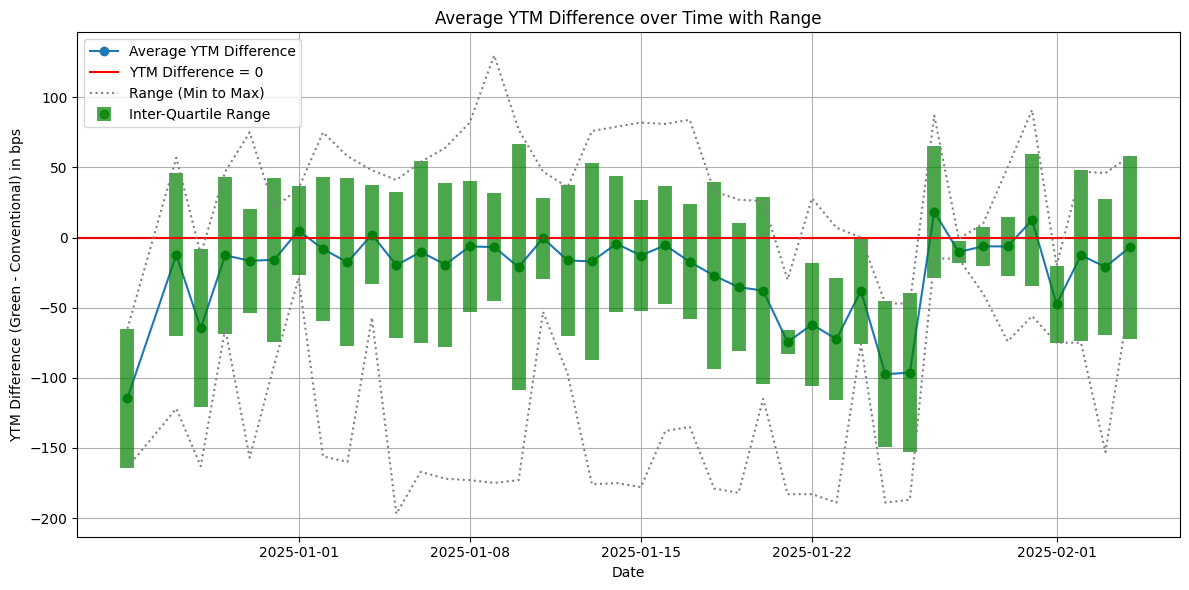

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the DateTime columns are datetime objects
df_matched['Green_Bond_DateTime'] = pd.to_datetime(df_matched['Green_Bond_DateTime'])
df_matched['Conv_Bond_DateTime'] = pd.to_datetime(df_matched['Conv_Bond_DateTime'])

# Compute a pair date as the midpoint between green and conventional observation times
# Convert to int64 (nanoseconds since epoch), average, then convert back to datetime
df_matched['pair_date'] = pd.to_datetime(
    (df_matched['Green_Bond_DateTime'].astype(np.int64) + df_matched['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# If you prefer daily averages, extract the date portion (drop the time)
df_matched['pair_date'] = df_matched['pair_date'].dt.date

# Group by the pair_date and calculate the average YTM difference for each day
daily_stats = df_matched.groupby('pair_date').agg(
	mean=('YTM_diff', 'mean'),
	min=('YTM_diff', 'min'),
	max=('YTM_diff', 'max'),
	quant75=('YTM_diff', lambda x: x.quantile(0.75)),
	quant25=('YTM_diff', lambda x: x.quantile(0.25))
).reset_index()
iqr = daily_stats['quant75'] - daily_stats['quant25']

# Convert pair_date back to datetime for plotting
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# Create the plot with mean and range
plt.figure(figsize=(12, 6))

# Plot the average line
plt.plot(daily_stats['pair_date'], daily_stats['mean'] * 100, marker='o', linestyle='-', label='Average YTM Difference')

# Plot the range as a boxplot line
plt.errorbar(daily_stats['pair_date'], daily_stats['min'] * 100, linestyle=':', color='grey', label='Range (Min to Max)', capsize=5)
plt.errorbar(daily_stats['pair_date'], daily_stats['max'] * 100, linestyle=':', color='grey')
# Add interquartile range (IQR) as a green box around the mean
plt.errorbar(daily_stats['pair_date'], daily_stats['mean'] * 100, yerr = iqr * 100, color='green', label='Inter-Quartile Range', alpha = 0.7, fmt='o', elinewidth=10, capthick=10)

# Adding y = 0
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')
plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional) in bps')
plt.title('Average YTM Difference over Time with Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
# get list of all dates in the data set
print(daily_stats[daily_stats['pair_date']=='2025-01-25'])
# we order the data by min
daily_stats = daily_stats.sort_values('min')
daily_stats.head()
print(daily_stats.mean())

    pair_date   mean   min   max  quant75  quant25
30 2025-01-25 -0.975 -1.89 -0.47  -0.6125  -1.1325
pair_date    2025-01-14 23:24:52.682926848
mean                             -0.252058
min                              -1.268537
max                               0.399268
quant75                           0.020793
quant25                          -0.449146
dtype: object


We investigate what is causing these extreme values

In [49]:
extreme_dates = daily_stats.head()['pair_date']
print(extreme_dates)

# Ensure the DateTime columns are datetime objects
df_matched['Green_Bond_DateTime'] = pd.to_datetime(df_matched['Green_Bond_DateTime'])
df_matched['Conv_Bond_DateTime'] = pd.to_datetime(df_matched['Conv_Bond_DateTime'])
df_matched['pair_date'] = pd.to_datetime(
    (df_matched['Green_Bond_DateTime'].astype(np.int64) + df_matched['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# looking at the df we used to calculate the average yields, only looking at the first extreme date: 2025-01-14
# df_matched[df_matched['pair_date'] == extreme_dates.iloc[0]].sort_values('YTM_diff')

# we want to only extract the date from pair_date from the df_matched, it contains the date and time, but we want to match by date only
df_matched['pair_date'] = df_matched['pair_date'].dt.date
df_matched['pair_date'] = pd.to_datetime(df_matched['pair_date'])
df_matched[df_matched['pair_date'] == '2025-01-25'].sort_values('YTM_diff').head()

10   2025-01-05
30   2025-01-25
28   2025-01-23
31   2025-01-26
27   2025-01-22
Name: pair_date, dtype: datetime64[ns]


,Company,Green_Bond_ISIN,Green_Bond_Name,Green_Bond_Coupon,Green_Bond_Maturity,Green_Bond_Emission_Year,Green_Bond_YTM,Green_Bond_Price,Green_Bond_Mdur,Green_Bond_DateTime,...,Conv_Bond_YTM,Conv_Bond_Price,Conv_Bond_Mdur,Conv_Bond_DateTime,Matching_Distance,YTM_diff,Mdur_diff,Coupon_diff,days_to_maturity_diff,pair_date
279,raiffeisen bank international ag,xs2353473692,"Raiffeisen Bank International AG 1,375% 21/33",1.375,3056,2021,2.40,92.22,NaN,2025-02-03 10:01:00+00:00,...,4.29,100.89,NaN,2025-01-16 17:00:00+00:00,3.573818,-1.89,NaN,-3.375,2316,2025-01-25
324,mizuho financial group inc,xs2528323780,"Mizuho Financial Group Inc. 3,49% 22/27",3.490,944,2022,2.71,101.94,2.292,2025-02-03 10:01:00+00:00,...,3.59,90.45,5.253,2025-01-16 17:00:00+00:00,3.122337,-0.88,-2.961,1.394,-1695,2025-01-25
563,caisse francaise de financement local,fr001400dxr9,"Caisse Francaise de Financement Local 3,125% 2...",3.125,1016,2022,2.58,101.46,2.467,2025-02-03 10:01:00+00:00,...,3.24,99.08,5.991,2025-01-16 09:26:00+00:00,3.437942,-0.66,-3.524,0.000,-2218,2025-01-25
325,mizuho financial group inc,xs2672418055,"Mizuho Financial Group Inc. 4,608% 23/30",4.608,2032,2023,3.14,107.54,4.239,2025-02-03 10:01:00+00:00,...,3.61,90.31,5.253,2025-01-16 13:00:00+00:00,3.323706,-0.47,-1.014,2.512,-607,2025-01-25


Before removing the observations of non euro currencies we had problems of bonds denoted in other currencies due to the large differences in yields sometimes present. We see the problem is caused by a bond denominated in turkish lira TRY, from "Instituto de Credito Oficial 29% 24/33" so we drop this one, and repeat the process for other extreme outliers

### Plot average distance measure and number of observations over time

we visualise the amount of observations per date and the mean and weighted mean distance measure over time

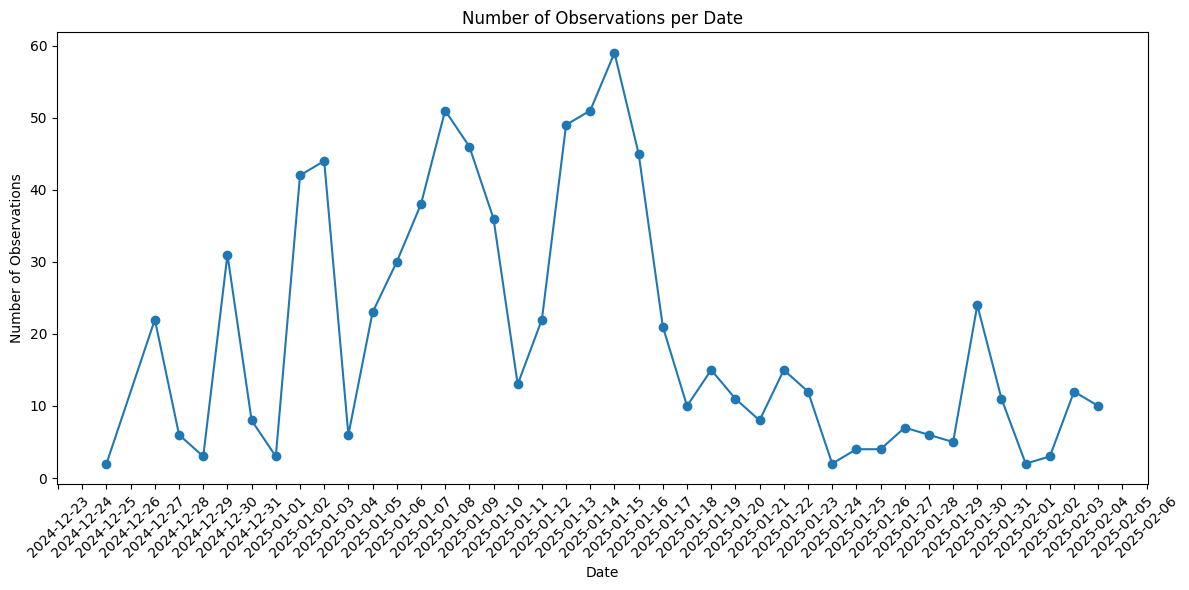

In [50]:
import matplotlib.dates as mdates

date_counts = df_matched['pair_date'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(date_counts.index, date_counts.values, marker='o', linestyle='-')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Observations')
ax.set_title('Number of Observations per Date')

# Set the x-axis to show every day
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Weighted Average Plot of YTM_Difference over time

To compare we not weight the differences in YTM between green and conventional bonds by the distance measure, more concretely, rescaling them. 
We weight the bond pairs by $ 1 / (1 + MatchingDistance)$ giving a larger weight to bonds that are closer in characteristics.

C:\Users\Alex\AppData\Local\Temp\ipykernel_6736\4092518375.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


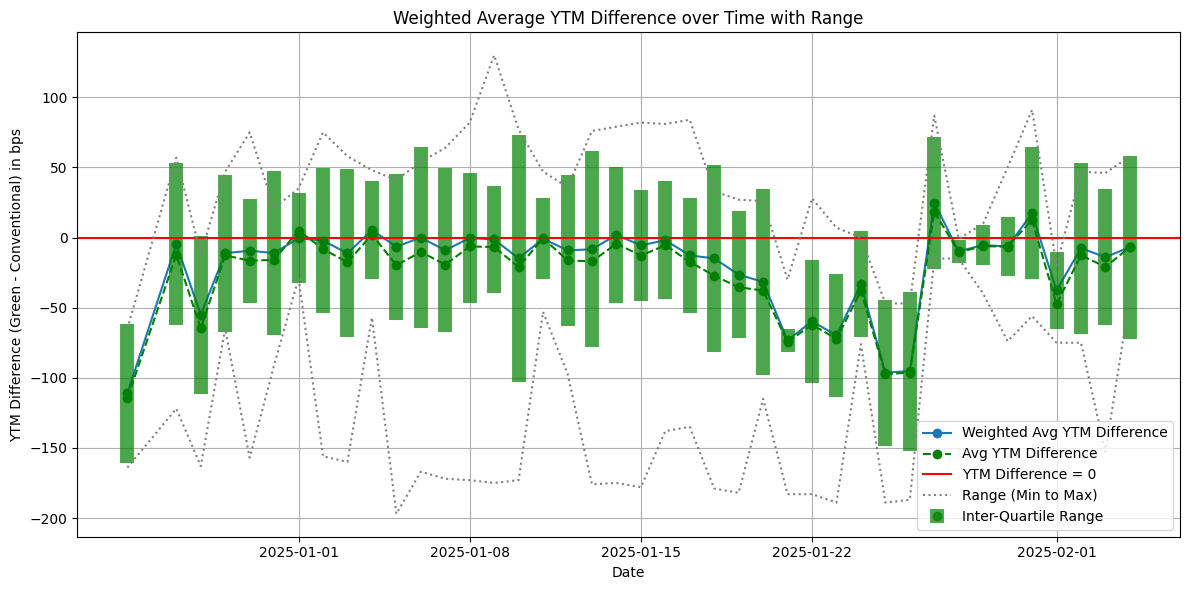

In [51]:
# Ensure the DateTime columns are datetime objects
df_matched['Green_Bond_DateTime'] = pd.to_datetime(df_matched['Green_Bond_DateTime'])
df_matched['Conv_Bond_DateTime'] = pd.to_datetime(df_matched['Conv_Bond_DateTime'])

# Compute a pair date as the midpoint between green and conventional observation times
df_matched['pair_date'] = pd.to_datetime(
    (df_matched['Green_Bond_DateTime'].astype(np.int64) + df_matched['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# If you prefer daily data, drop the time portion
df_matched['pair_date'] = df_matched['pair_date'].dt.date

# ------------------------------------------------------------------------------
#    weight = 1 / (1 + Matching_Distance)
# ------------------------------------------------------------------------------
df_matched['weight'] = 1 / (1 + df_matched['Matching_Distance'])

# ------------------------------------------------------------------------------
# 2) Compute a weighted average YTM_diff for each date
# ------------------------------------------------------------------------------

def weighted_avg(values, weights):
    """Compute the weighted average of 'values' using 'weights'."""
    return np.average(values, weights=weights)

# We also keep track of min and max for a shaded range plot
daily_stats = (
    df_matched
    .groupby('pair_date')
    .apply(lambda group: pd.Series({
        'weighted_mean': weighted_avg(group['YTM_diff'], group['weight']),
        'mean': group['YTM_diff'].mean(),
        'min': group['YTM_diff'].min(),
        'max': group['YTM_diff'].max()
    }))
    .reset_index()
)

quantiles = df_matched.groupby('pair_date').agg(
    quant75=('YTM_diff', lambda x: x.quantile(0.75)), 
    quant25=('YTM_diff', lambda x: x.quantile(0.25))
).reset_index()

daily_stats = daily_stats.merge(quantiles, on='pair_date')
iqr = daily_stats['quant75'] - daily_stats['quant25']

# Convert pair_date back to datetime for plotting
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# ------------------------------------------------------------------------------
# 3) Plot the weighted average line along with the min-max range
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))

# Weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['weighted_mean'] * 100,
    marker='o', linestyle='-',
    label='Weighted Avg YTM Difference'
)

# Previous non-weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['mean'] * 100,
    marker='o', linestyle='--',
    label='Avg YTM Difference',
    color='green'
)

# Plot the range as a boxplot line
plt.errorbar(daily_stats['pair_date'], daily_stats['min'] * 100, linestyle=':', color='grey', label='Range (Min to Max)', capsize=5)
plt.errorbar(daily_stats['pair_date'], daily_stats['max'] * 100, linestyle=':', color='grey')
# Add interquartile range (IQR) as a green box around the mean
plt.errorbar(daily_stats['pair_date'], daily_stats['weighted_mean'] * 100, yerr = iqr * 100, color='green', label='Inter-Quartile Range', alpha = 0.7, fmt='o', elinewidth=10, capthick=10)
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')
plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional) in bps')
plt.title('Weighted Average YTM Difference over Time with Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We see a greenium through time, even if it is close to 0 bps at time. We are unsure if it is significantly different from zero however.

In [52]:
print("For the One-to-One matching method We get the following results:")
print(f"Arithmetic mean:{daily_stats['mean'].mean()}")
print(f"Weighted mean:{daily_stats['weighted_mean'].mean()}")
# Standard deviation of the YTM difference
print(f"Arithmetic mean standard deviation:{daily_stats['mean'].std()}")
print(f"Weighted mean standard deviation:{daily_stats['weighted_mean'].std()}")

# Install Jinja2 (required for to_latex())
# %pip install jinja2

# print to latex
# Also export to LaTeX file
with open('daily_stats_results.tex', 'w') as f:
    f.write(daily_stats.to_latex(index=False))
    
# Still print to console for quick inspection
# print(daily_stats.to_latex(index=False))

For the One-to-One matching method We get the following results:
Arithmetic mean:-0.25205798672702756
Weighted mean:-0.20142061686540666
Arithmetic mean standard deviation:0.30336147149301423
Weighted mean standard deviation:0.3078645291883635


## OLS test for One-to-One Matching with Weights

We perform a OLS with the weights we created before with Newey-West standard errors accounting for serial correlation and also with clustered standard error to compare the results

Simple t-test results:
t-statistic: -9.1160, p-value: 0.0000
Mean YTM_diff: -0.1629

Ljung-Box test for autocorrelation:
      lb_stat  lb_pvalue
1    3.339037   0.067654
5   11.696473   0.039192
10  18.876454   0.041860

Time-series regression with Newey-West standard errors:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2521      0.064     -3.943      0.000      -0.377      -0.127

Panel regression with clustering by company:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1629      0.081     -2.007      0.045      -0.322      -0.004


C:\Users\Alex\AppData\Local\Temp\ipykernel_6736\3668543989.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ci_lower = (results_nw.params[0] - 1.96 * results_nw.bse[0]) * 100
C:\Users\Alex\AppData\Local\Temp\ipykernel_6736\3668543989.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ci_upper = (results_nw.params[0] + 1.96 * results_nw.bse[0]) * 100
C:\Users\Alex\AppData\Local\Temp\ipykernel_6736\3668543989.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

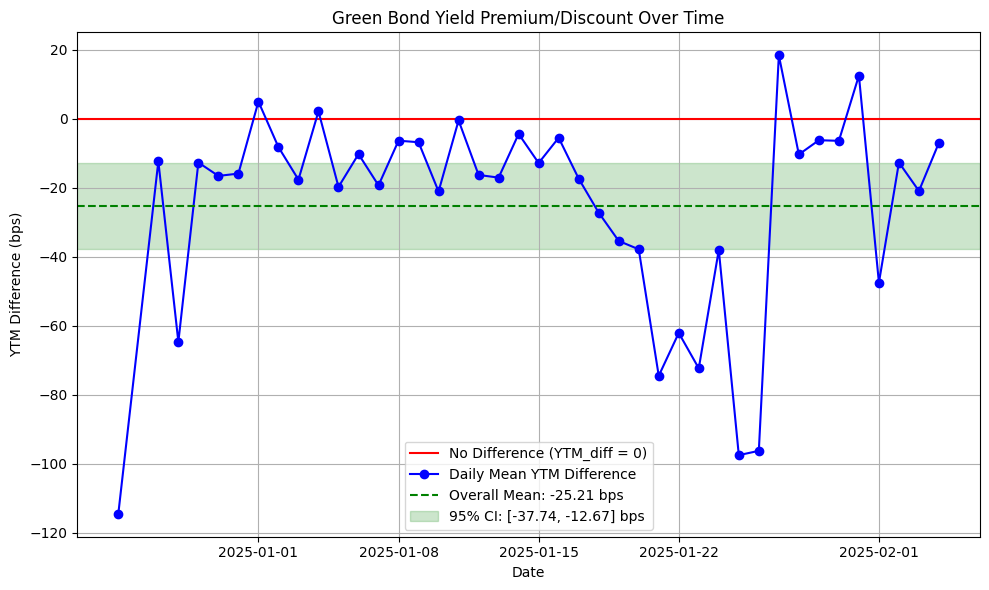

In [53]:
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1. Basic t-test on the YTM difference
t_stat, p_value = stats.ttest_1samp(df_matched['YTM_diff'].dropna(), 0)
print(f"Simple t-test results:")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
print(f"Mean YTM_diff: {df_matched['YTM_diff'].mean():.4f}")

# 2. Check for autocorrelation in the time series
# First, aggregate by date to get daily average YTM differences
daily_ytm = df_matched.groupby('pair_date')['YTM_diff'].mean().reset_index()
daily_ytm = daily_ytm.sort_values('pair_date').set_index('pair_date')

# Test for autocorrelation using Ljung-Box test
lb_test = acorr_ljungbox(daily_ytm['YTM_diff'], lags=[1, 5, 10])
print("\nLjung-Box test for autocorrelation:")
print(lb_test)

# 3. Time-series regression with Newey-West standard errors
# Set up a constant-only model to test if the mean is different from zero
X = sm.add_constant(np.ones(len(daily_ytm)))
y = daily_ytm['YTM_diff']

# Calculate maximum lag for Newey-West based on sample size
maxlag = int(4 * (len(daily_ytm)/100)**(2/9))
maxlag = max(1, maxlag)  # Ensure at least lag 1

# Run regression with Newey-West correction for autocorrelation
model_nw = sm.OLS(y, sm.add_constant(np.ones(len(y))))
results_nw = model_nw.fit(cov_type='HAC', cov_kwds={'maxlags': maxlag})
print("\nTime-series regression with Newey-West standard errors:")
print(results_nw.summary().tables[1])

# 4. Panel regression with time fixed effects and clustering
# This approach accounts for both time effects and company-level clustering
# Ensure YTM_diff and relevant columns are available
df_panel = df_matched[['Company', 'pair_date', 'YTM_diff', 'Matching_Distance',
                       'Coupon_diff', 'days_to_maturity_diff']].dropna()

# Convert to proper datetime for panel regression
df_panel['pair_date'] = pd.to_datetime(df_panel['pair_date'])
df_panel = df_panel.set_index(['Company', 'pair_date'])

# Run panel regression with company fixed effects
import statsmodels.formula.api as smf
model_panel = smf.ols('YTM_diff ~ 1', data=df_panel)
results_panel = model_panel.fit(cov_type='cluster', cov_kwds={'groups': df_panel.index.get_level_values(0)})
print("\nPanel regression with clustering by company:")
print(results_panel.summary().tables[1])

# 5. Visualize the results with confidence intervals
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='r', linestyle='-', label='No Difference (YTM_diff = 0)')
plt.plot(daily_ytm.index, daily_ytm['YTM_diff'] * 100, 'bo-', label='Daily Mean YTM Difference')

# Add confidence interval from Newey-West regression
ci_lower = (results_nw.params[0] - 1.96 * results_nw.bse[0]) * 100
ci_upper = (results_nw.params[0] + 1.96 * results_nw.bse[0]) * 100
plt.axhline(y=results_nw.params[0] * 100, color='g', linestyle='--', 
            label=f'Overall Mean: {results_nw.params[0]*100:.2f} bps')
plt.axhspan(ci_lower, ci_upper, alpha=0.2, color='g', 
            label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}] bps')

plt.xlabel('Date')
plt.ylabel('YTM Difference (bps)')
plt.title('Green Bond Yield Premium/Discount Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Winsorising and reformating
I delete the extreme value to have a better look at the dynamics

C:\Users\Alex\AppData\Local\Temp\ipykernel_6736\2288165081.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


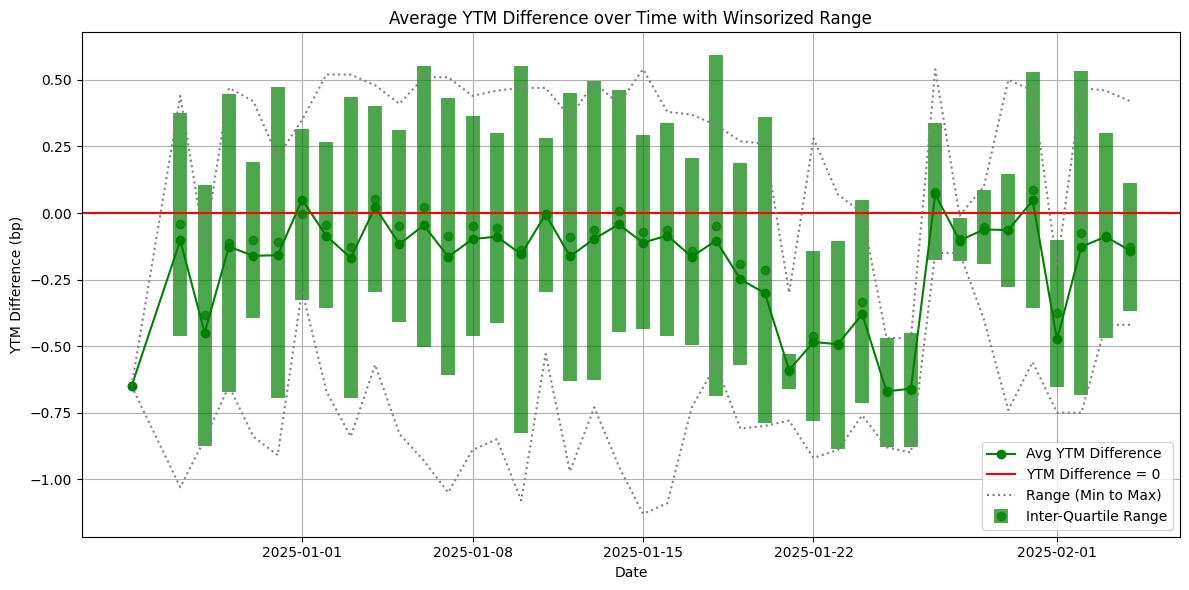

In [63]:
# Ensure the DateTime columns are datetime objects
df_matched['Green_Bond_DateTime'] = pd.to_datetime(df_matched['Green_Bond_DateTime'])
df_matched['Conv_Bond_DateTime'] = pd.to_datetime(df_matched['Conv_Bond_DateTime'])

# Compute a pair date as the midpoint between green and conventional observation times
# Convert to int64 (nanoseconds since epoch), average, then convert back to datetime
df_matched['pair_date'] = pd.to_datetime(
    (df_matched['Green_Bond_DateTime'].astype(np.int64) + df_matched['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# If you prefer daily averages, extract the date portion (drop the time)
df_matched['pair_date'] = df_matched['pair_date'].dt.date

# Convert YTM_diff from percentage to basis points (1% = 100 bp)
df_matched['YTM_diff'] = df_matched['YTM_diff']

# remove extreme quantiles from df_matched
df_matched = df_matched[(df_matched['YTM_diff'] > df_matched['YTM_diff'].quantile(0.05)) &
                        (df_matched['YTM_diff'] < df_matched['YTM_diff'].quantile(0.95))]

# We also keep track of min and max for a shaded range plot
daily_stats = (
    df_matched
    .groupby('pair_date')
    .apply(lambda group: pd.Series({
        'weighted_mean': weighted_avg(group['YTM_diff'], group['weight']),
        'mean': group['YTM_diff'].mean(),
        'min': group['YTM_diff'].min(),
        'max': group['YTM_diff'].max()
    }))
    .reset_index()
)

quantiles = df_matched.groupby('pair_date').agg(
    quant75=('YTM_diff', lambda x: x.quantile(0.75)), 
    quant25=('YTM_diff', lambda x: x.quantile(0.25))
).reset_index()

daily_stats = daily_stats.merge(quantiles, on='pair_date')
iqr = daily_stats['quant75'] - daily_stats['quant25']

# Convert pair_date back to datetime for plotting
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# Create the plot with mean and the winsorized range
plt.figure(figsize=(12, 6))

# Previous non-weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['mean'],
    marker='o', linestyle='-',
    label='Avg YTM Difference',
    color='green'
)

# Plot the range as a boxplot line
plt.errorbar(daily_stats['pair_date'], daily_stats['min'], linestyle=':', color='grey', label='Range (Min to Max)', capsize=5)
plt.errorbar(daily_stats['pair_date'], daily_stats['max'], linestyle=':', color='grey')
# Add interquartile range (IQR) as a green box around the mean
plt.errorbar(daily_stats['pair_date'], daily_stats['weighted_mean'], yerr = iqr, color='green', label='Inter-Quartile Range', alpha = 0.7, fmt='o', elinewidth=10, capthick=10)
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')

plt.xlabel('Date')
plt.ylabel('YTM Difference (bp)')
plt.title('Average YTM Difference over Time with Winsorized Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
print(daily_stats['mean'].mean())
print(daily_stats['weighted_mean'].mean())

-0.19621032395894983
-0.16357293673422504


Winzorising does not seem to have a major effect. so maybe not include in paper, only as robustness check.

# 3 - One-to-Many Matching
Does this significantly change our results?

In [67]:
def match_green_bonds_one_green_many(df, time_weight=1.0):
    """
    For each issuer (Company), match each green bond observation to every distinct
    conventional bond ISIN, but only to the single time entry that is closest in
    DateTime for that bond.

    This results in multiple matches per green bond (one for each conventional bond),
    but avoids matching the green bond with multiple time observations of the same
    conventional bond.
    """
    # --- Copy data and convert relevant columns to numeric
    df = df.copy()
    df['YTM'] = pd.to_numeric(df['YTM'], errors='coerce')
    df['Coupon'] = pd.to_numeric(df['Coupon'], errors='coerce')
    df['days_to_maturity'] = pd.to_numeric(df['days_to_maturity'], errors='coerce')
    df['Modified_Duration'] = pd.to_numeric(df['Modified_Duration'], errors='coerce')
    df['Last Price'] = pd.to_numeric(df['Last Price'], errors='coerce')

    # --- Identify emission_year
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    def get_emission_year(row):
        for col in emission_cols:
            if row.get(col) is True:
                # remove potential trailing ".0" and convert to int
                return int(col.split('_')[-1].split('.')[0])
        return np.nan

    df['emission_year'] = df.apply(get_emission_year, axis=1)

    # --- Convert DateTime to numeric (days since epoch)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Time'] = df['DateTime'].astype(np.int64) / (1e9 * 3600 * 24)

    # Sort by DateTime to keep chronological order
    df_sorted = df.sort_values('DateTime')

    matched_results = []

    # --- Loop over each company that has both green and conventional observations
    for company in df_sorted['Company'].unique():
        comp_df = df_sorted[df_sorted['Company'] == company]
        if not (comp_df['is_green'].eq(1).any() and comp_df['is_green'].eq(0).any()):
            continue

        # Split into green and conventional
        green_df = comp_df[comp_df['is_green'] == 1].reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].reset_index(drop=True)

        # Define features for distance calculation
        features = ['Coupon', 'days_to_maturity', 'emission_year', 'Time']

        # Standardize these features across all observations for the company
        combined = comp_df[features]
        means = combined.mean()
        stds = combined.std()

        # Create scaled versions
        green_scaled = (green_df[features] - means) / stds
        conv_scaled = (conv_df[features] - means) / stds

        # Down-weight coupon differences
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight

        # Optionally scale the time feature
        green_scaled['Time'] *= time_weight
        conv_scaled['Time'] *= time_weight

        # Convert scaled DataFrames to numpy arrays
        green_mat = green_scaled.values
        conv_mat = conv_scaled.values

        # Map the original conv_df index to the row in conv_mat
        conv_index_map = {idx: i for i, idx in enumerate(conv_df.index)}

        # --- For each green row, match to each conventional bond ISIN's single closest time
        for g_idx, g_row in green_df.iterrows():
            # We'll create multiple matches for each green bond row:
            # one match per distinct conventional bond ISIN.
            green_time = g_row['Time']
            green_scaled_vec = green_mat[g_idx]  # scaled vector for distance

            for conv_isin in conv_df['ISIN'].unique():
                # Filter to just this ISIN's rows
                subset = conv_df[conv_df['ISIN'] == conv_isin].copy()
                if subset.empty:
                    continue

                # Find the row with the minimal absolute time difference
                subset['abs_time_diff'] = (subset['Time'] - green_time).abs()
                closest_idx = subset['abs_time_diff'].idxmin()
                c_row = subset.loc[closest_idx]

                # Retrieve the scaled vector for that same row
                c_scaled_vec = conv_mat[conv_index_map[closest_idx]]

                # Compute Euclidean distance across scaled features
                dist_val = np.sqrt(((green_scaled_vec - c_scaled_vec) ** 2).sum())

                # Store the match
                matched_results.append({
                    'Company': company,

                    'Green_Bond_ISIN': g_row['ISIN'],
                    'Green_Bond_Name': g_row.get('Name', 'Unknown'),
                    'Green_Bond_Coupon': g_row['Coupon'],
                    'Green_Bond_Maturity': g_row['days_to_maturity'],
                    'Green_Bond_Emission_Year': g_row['emission_year'],
                    'Green_Bond_YTM': g_row['YTM'],
                    'Green_Bond_Price': g_row['Last Price'],
                    'Green_Bond_Mdur': g_row['Modified_Duration'],
                    'Green_Bond_DateTime': g_row['DateTime'],

                    'Conv_Bond_ISIN': c_row['ISIN'],
                    'Conv_Bond_Name': c_row.get('Name', 'Unknown'),
                    'Conv_Bond_Coupon': c_row['Coupon'],
                    'Conv_Bond_Maturity': c_row['days_to_maturity'],
                    'Conv_Bond_Emission_Year': c_row['emission_year'],
                    'Conv_Bond_YTM': c_row['YTM'],
                    'Conv_Bond_Price': c_row['Last Price'],
                    'Conv_Bond_Mdur': c_row['Modified_Duration'],
                    'Conv_Bond_DateTime': c_row['DateTime'],

                    'Distance': dist_val,
                    'Time_Diff': c_row['abs_time_diff']  # optional
                })

    return pd.DataFrame(matched_results)

In [68]:
df_greedy = match_green_bonds_one_green_many(df_for_matching)
df_greedy

,Company,Green_Bond_ISIN,Green_Bond_Name,Green_Bond_Coupon,Green_Bond_Maturity,Green_Bond_Emission_Year,Green_Bond_YTM,Green_Bond_Price,Green_Bond_Mdur,Green_Bond_DateTime,...,Conv_Bond_Name,Conv_Bond_Coupon,Conv_Bond_Maturity,Conv_Bond_Emission_Year,Conv_Bond_YTM,Conv_Bond_Price,Conv_Bond_Mdur,Conv_Bond_DateTime,Distance,Time_Diff
0,rwe ag,xs2482887879,"RWE AG 2,75% 22/30",2.750,1978,2022,2.92,99.16,4.249,2024-12-23 08:03:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,2.499591,10.225694
1,rwe ag,xs2482887879,"RWE AG 2,75% 22/30",2.750,1974,2022,3.16,97.96,4.249,2024-12-27 09:25:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,2.390110,6.168750
2,rwe ag,xs2584685387,"RWE AG 4,125% 23/35",4.125,3700,2023,3.68,103.80,5.988,2024-12-27 10:29:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,1.570557,6.124306
3,rwe ag,xs2412044567,"RWE AG 0,5% 21/28",0.500,1430,2021,2.82,91.38,3.367,2024-12-27 10:29:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,3.721349,6.124306
4,rwe ag,xs2412044641,RWE AG 1% 21/33,1.000,3256,2021,3.50,80.74,6.239,2024-12-27 10:29:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,3.596425,6.124306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16923,bayerische landesbank,xs2411178630,"Bayerische Landesbank 1,375% 21/32",1.375,2849,2021,2.20,94.06,NaN,2025-02-03 16:20:00+00:00,...,"Bayerische Landesbank 2,875% 24/28",2.875,1399,2024,2.61,100.95,3.269,2025-01-14 13:46:00+00:00,12.600120,20.106944
16924,bayerische landesbank,xs2411178630,"Bayerische Landesbank 1,375% 21/32",1.375,2848,2021,2.21,94.02,NaN,2025-02-04 08:47:00+00:00,...,"Bayerische Landesbank 2,875% 24/28",2.875,1399,2024,2.61,100.95,3.269,2025-01-14 13:46:00+00:00,12.605453,20.792361
16925,bayerische landesbank,xs2411178630,"Bayerische Landesbank 1,375% 21/32",1.375,2848,2021,2.21,94.03,NaN,2025-02-04 10:47:00+00:00,...,"Bayerische Landesbank 2,875% 24/28",2.875,1399,2024,2.61,100.95,3.269,2025-01-14 13:46:00+00:00,12.606574,20.875694
16926,bayerische landesbank,xs2411178630,"Bayerische Landesbank 1,375% 21/32",1.375,2848,2021,2.21,94.03,NaN,2025-02-04 14:47:00+00:00,...,"Bayerische Landesbank 2,875% 24/28",2.875,1399,2024,2.61,100.95,3.269,2025-01-14 13:46:00+00:00,12.608829,21.042361


In [69]:
# Create a new column for the YTM difference (green bond YTM minus conventional bond YTM)
df_greedy['YTM_diff'] = df_greedy['Green_Bond_YTM'] - df_greedy['Conv_Bond_YTM']
df_greedy['Mdur_diff'] = df_greedy['Green_Bond_Mdur'] - df_greedy['Conv_Bond_Mdur']
df_greedy['Coupon_diff'] = df_greedy['Green_Bond_Coupon'] - df_greedy['Conv_Bond_Coupon']
df_greedy['days_to_maturity_diff'] = df_greedy['Green_Bond_Maturity'] - df_greedy['Conv_Bond_Maturity']
print(df_greedy.head())
print(df_greedy['YTM_diff'].describe())

  Company Green_Bond_ISIN      Green_Bond_Name  Green_Bond_Coupon  \
0  rwe ag    xs2482887879   RWE AG 2,75% 22/30              2.750   
1  rwe ag    xs2482887879   RWE AG 2,75% 22/30              2.750   
2  rwe ag    xs2584685387  RWE AG 4,125% 23/35              4.125   
3  rwe ag    xs2412044567    RWE AG 0,5% 21/28              0.500   
4  rwe ag    xs2412044641      RWE AG 1% 21/33              1.000   

   Green_Bond_Maturity  Green_Bond_Emission_Year  Green_Bond_YTM  \
0                 1978                      2022            2.92   
1                 1974                      2022            3.16   
2                 3700                      2023            3.68   
3                 1430                      2021            2.82   
4                 3256                      2021            3.50   

   Green_Bond_Price  Green_Bond_Mdur       Green_Bond_DateTime  ...  \
0             99.16            4.249 2024-12-23 08:03:00+00:00  ...   
1             97.96            4.2

C:\Users\Alex\AppData\Local\Temp\ipykernel_6736\327332063.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


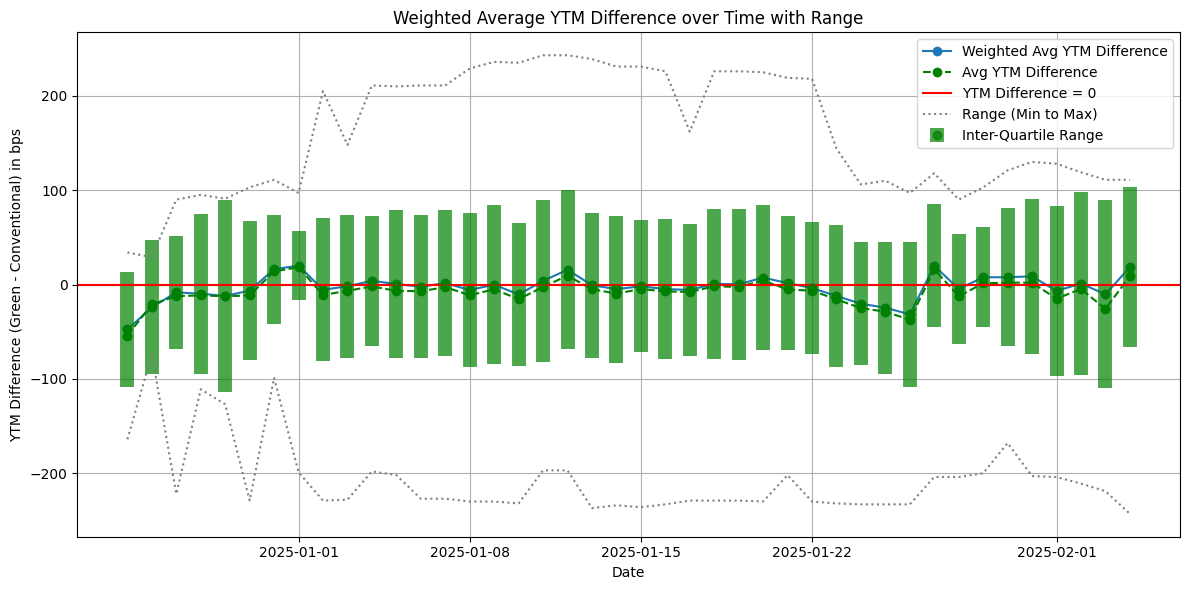

In [70]:
# 1. Convert the DateTime columns to actual datetime objects
df_greedy['Green_Bond_DateTime'] = pd.to_datetime(df_greedy['Green_Bond_DateTime'])
df_greedy['Conv_Bond_DateTime'] = pd.to_datetime(df_greedy['Conv_Bond_DateTime'])

# 2. Compute a midpoint 'pair_date' between green and conventional bond DateTime
df_greedy['pair_date'] = pd.to_datetime(
    (df_greedy['Green_Bond_DateTime'].astype(np.int64) + df_greedy['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# 3. If you prefer daily data (no time component), extract just the date
df_greedy['pair_date'] = df_greedy['pair_date'].dt.date

# 4. Create a weight based on the distance
df_greedy['weight'] = 1 / (1 + df_greedy['Distance'])

# 5. Define a helper function for weighted averages
def weighted_avg(values, weights):
    """Compute the weighted average of 'values' using 'weights'."""
    return np.average(values, weights=weights)

# 6. Group by date and compute statistics
daily_stats_one_to_many = (
    df_greedy
    .groupby('pair_date')
    .apply(lambda group: pd.Series({
        'weighted_mean': weighted_avg(group['YTM_diff'], group['weight']),
        'mean': group['YTM_diff'].mean(),
        'min': group['YTM_diff'].min(),
        'max': group['YTM_diff'].max()
    }))
    .reset_index()
)

# 7. Calculate the 25th and 75th percentiles for IQR
quantiles = (
    df_greedy
    .groupby('pair_date')
    .agg(
        quant75=('YTM_diff', lambda x: x.quantile(0.75)),
        quant25=('YTM_diff', lambda x: x.quantile(0.25))
    )
    .reset_index()
)

# 8. Merge percentile data into daily_stats
daily_stats_one_to_many = daily_stats_one_to_many.merge(quantiles, on='pair_date', how='left')
iqr = daily_stats_one_to_many['quant75'] - daily_stats_one_to_many['quant25']

# 9. Convert pair_date back to datetime (optional for plotting)
daily_stats_one_to_many['pair_date'] = pd.to_datetime(daily_stats_one_to_many['pair_date'])

# 10. Plot the results
plt.figure(figsize=(12, 6))

# Weighted average line
plt.plot(
    daily_stats_one_to_many['pair_date'],
    daily_stats_one_to_many['weighted_mean'] * 100,   # convert to basis points
    marker='o',
    linestyle='-',
    label='Weighted Avg YTM Difference'
)

# Non-weighted average line
plt.plot(
    daily_stats_one_to_many['pair_date'],
    daily_stats_one_to_many['mean'] * 100,            # convert to basis points
    marker='o',
    linestyle='--',
    color='green',
    label='Avg YTM Difference'
)

# Plot the min-max range as “error bars”
plt.errorbar(
    daily_stats_one_to_many['pair_date'],
    daily_stats_one_to_many['min'] * 100,
    linestyle=':',
    color='grey',
    label='Range (Min to Max)',
    capsize=5
)
plt.errorbar(
    daily_stats_one_to_many['pair_date'],
    daily_stats_one_to_many['max'] * 100,
    linestyle=':',
    color='grey'
)

# Plot the IQR around the weighted mean
plt.errorbar(
    daily_stats_one_to_many['pair_date'],
    daily_stats_one_to_many['weighted_mean'] * 100,
    yerr=iqr * 100,
    color='green',
    label='Inter-Quartile Range',
    alpha=0.7,
    fmt='o',
    elinewidth=10,
    capthick=10
)

# Horizontal line at zero difference
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')

plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional) in bps')
plt.title('Weighted Average YTM Difference over Time with Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The one-to-many matching method produces results that are much more centered around 0. presumambly because we use similar bonds much more often in the analysis

In [72]:
# Mean YTM difference
print("For the One to Many matching Method:")
print(f"Arithmetic mean:{daily_stats_one_to_many['mean'].mean()}")
print(f"Weighted mean:{daily_stats_one_to_many['weighted_mean'].mean()}")
# Standard deviation of the YTM difference
print(f"Arithmetic mean standard deviation:{daily_stats_one_to_many['mean'].std()}")
print(f"Weighted mean standard deviation:{daily_stats_one_to_many['weighted_mean'].std()}")

# output to latex
with open('daily_stats_results_one_to_many.tex', 'w') as f:
    f.write(daily_stats_one_to_many.to_latex(index=False))

For the One to Many matching Method:
Arithmetic mean:-0.07933560229373796
Weighted mean:-0.031421117478276285
Arithmetic mean standard deviation:0.13493726318720478
Weighted mean standard deviation:0.13380907949835424


Using The One to Many matching method produces quite different results, giving us a weighted mean of $-0.03$ so a greenium of around 3 bps. 

# 4 - Using Pietsch and Salakhova Matching method

The matching method is based on Huang 1997 and Huang 1998

In [ ]:
df_for_matching.columns
print(df_for_matching.head().to_string())

Index(['Name', 'Clean_Company_Maturity', 'WKN', 'URL', 'ISIN', 'Company',
       'Kupon_Maturity', 'Coupon', 'Maturity_Start', 'Maturity_End',
       'is_green', 'Last Price', 'DateTime', 'Volume in Euro', '+/- %',
       'Currency', 'YTM', 'Modified_Duration', 'Kupon', 'Emittent', 'Branche',
       'Fälligkeit', 'Schuldnerkündigungsart', 'Sonderkündigung', 'Nachrangig',
       'Kleinste handelbare Einheit', 'Spezialist', 'Handelsmodell',
       'Emissionsdatum', 'Emissionsvolumen', 'Umlaufendes Volumen',
       'Emissionswährung', 'Depotwährung', 'Notierungsaufnahme',
       'Emission_year_2020.0', 'Emission_year_2021.0', 'Emission_year_2022.0',
       'Emission_year_2023.0', 'Emission_year_2024.0', 'Emission_year_2025.0',
       'Date', 'fälligkeit_datum', 'emission_datum', 'days_to_maturity'],
      dtype='object')

In [ ]:
from scipy.optimize import linear_sum_assignment

######################################
# 1) Define a helper function for distance
######################################
def k_prototypes_distance(g_row, c_row,
                          numeric_cols, numeric_weights,
                          cat_cols, cat_weights):
    dist_num = 0.0
    for col, w in zip(numeric_cols, numeric_weights):
        g_val = g_row[col]
        c_val = c_row[col]
        if pd.notna(g_val) and pd.notna(c_val):
            dist_num += w * (g_val - c_val) ** 2
    dist_cat = 0.0
    for col, w in zip(cat_cols, cat_weights):
        g_val = g_row[col]
        c_val = c_row[col]
        diff = 0 if (g_val == c_val) else 1
        dist_cat += w * diff
    return dist_num + dist_cat

######################################
# 2) Copy and prepare your DataFrame
######################################
df_debug = df_for_matching.copy()  # Replace with your actual DataFrame variable
df_debug['DateTime'] = pd.to_datetime(df_debug['DateTime'], errors='coerce')

# Choose numeric & categorical columns, plus their weights
numeric_cols = ['Coupon', 'Maturity_Start', 'Maturity_End',
                'Modified_Duration', 'days_to_maturity']
numeric_weights = [20.0, 50.0, 50.0, 20.0, 100.0]

cat_cols = ['emission_datum', 'Currency']
cat_weights = [0.5, 100.0]

# Convert numeric columns to floats
for col in numeric_cols:
    df_debug[col] = pd.to_numeric(df_debug[col], errors='coerce')

# Create a daily grouping by extracting the date (no time)
df_debug['Date'] = df_debug['DateTime'].dt.date

# We'll store the matched results in a list of dicts
matched_results = []

######################################
# 3) Loop over each issuer (Company)
######################################
companies = df_debug['Company'].unique()
print("Companies:", companies)

for company in companies:
    print(f"\n=== Processing Company: {company} ===")
    
    comp_df = df_debug[df_debug['Company'] == company].copy()
    # Only proceed if we have both green and conventional for this company
    if not (1 in comp_df['is_green'].values and 0 in comp_df['is_green'].values):
        print("  Skipping: no green or no conventional bonds for this company.")
        continue

    ######################################
    # 4) For each day
    ######################################
    unique_dates = comp_df['Date'].unique()
    print("  Dates found:", unique_dates)

    for single_date in unique_dates:
        print(f"  -- Date: {single_date} --")
        day_df = comp_df[comp_df['Date'] == single_date].copy()

        # Separate green vs. conventional
        green_df = day_df[day_df['is_green'] == 1].reset_index(drop=True)
        conv_df = day_df[day_df['is_green'] == 0].reset_index(drop=True)

        # If no green or no conventional on this date, skip
        if len(green_df) == 0 or len(conv_df) == 0:
            print("    Skipping: no green or no conventional on this date.")
            continue

        G = len(green_df)
        C = len(conv_df)
        print(f"    #Green = {G}, #Conventional = {C}")

        # Initialize distance matrix with inf
        dist_matrix = np.full((G, C), np.inf)

        ######################################
        # 5) Fill the distance matrix
        ######################################
        time_window_hours = 2.0  # Adjust if needed
        for g_idx, g_row in green_df.iterrows():
            g_time = g_row['DateTime']
            if pd.isna(g_time):
                continue
            for c_idx, c_row in conv_df.iterrows():
                c_time = c_row['DateTime']
                if pd.isna(c_time):
                    continue
                diff_hours = abs((g_time - c_time).total_seconds()) / 3600.0
                # Only fill if within time window
                if diff_hours <= time_window_hours:
                    dist_val = k_prototypes_distance(
                        g_row, c_row,
                        numeric_cols, numeric_weights,
                        cat_cols, cat_weights
                    )
                    dist_matrix[g_idx, c_idx] = dist_val

        # Print or debug the distance matrix if needed:
        # print("    dist_matrix:\n", dist_matrix)

        ######################################
        # 6) Skip rows (green bonds) that are all inf
        ######################################
        row_mask = ~np.isinf(dist_matrix).all(axis=1)
        dist_matrix_feasible = dist_matrix[row_mask, :]
        green_df_feasible = green_df.loc[row_mask].reset_index(drop=True)

        # 7) Skip columns (conv bonds) that are all inf
        col_mask = ~np.isinf(dist_matrix_feasible).all(axis=0)
        dist_matrix_feasible = dist_matrix_feasible[:, col_mask]
        conv_df_feasible = conv_df.loc[col_mask].reset_index(drop=True)

        # If no feasible rows/columns remain, skip
        if dist_matrix_feasible.size == 0:
            print("    Skipping: no feasible matches at all.")
            continue

        # If # feasible green > # feasible conv, skip to avoid Hungarian infeasibility
        if len(green_df_feasible) > len(conv_df_feasible):
            print("    Skipping: more feasible green than conventional.")
            continue

        ######################################
        # 8) Hungarian Algorithm
        ######################################
        print(f"    Running linear_sum_assignment on matrix {dist_matrix_feasible.shape}")
        row_ind_feasible, col_ind_feasible = linear_sum_assignment(dist_matrix_feasible)

        ######################################
        # 9) Collect matched pairs
        ######################################
        for r_f, c_f in zip(row_ind_feasible, col_ind_feasible):
            cost_val = dist_matrix_feasible[r_f, c_f]
            if cost_val < np.inf:
                g_match = green_df_feasible.iloc[r_f]
                c_match = conv_df_feasible.iloc[c_f]
                matched_results.append({
                    'Company': company,
                    'Date': single_date,

                    'Green_Bond_ISIN': g_match.get('ISIN', np.nan),
                    'Green_Bond_Name': g_match.get('Name', np.nan),
                    'Green_Bond_DateTime': g_match.get('DateTime', np.nan),
                    'Green_Bond_YTM': g_match.get('YTM', np.nan),

                    'Conv_Bond_ISIN': c_match.get('ISIN', np.nan),
                    'Conv_Bond_Name': c_match.get('Name', np.nan),
                    'Conv_Bond_DateTime': c_match.get('DateTime', np.nan),
                    'Conv_Bond_YTM': c_match.get('YTM', np.nan),

                    'KPrototypes_Distance': cost_val,
                    'Time_Diff_Hours': abs((g_match['DateTime'] - c_match['DateTime']).total_seconds()) / 3600.0
                })

######################################
# 10) Convert matched results to DataFrame
######################################
df_k_prototypes_debug = pd.DataFrame(matched_results)
print("\nFinal matched pairs:\n", df_k_prototypes_debug.head(20))
print("Number of matched pairs:", len(df_k_prototypes_debug))

Companies: ['e on se' 'landwirtschaftliche rentenbank' 'de volksbank n v'
 'volkswagen international finance n v' 'instituto de credito oficial'
 'national bank of greece s a' 'enbw international finance b v'
 'ungarn republik' 'mercedes benz group ag'
 'mercedes benz international finance b v'
 'japan finance organization for municipalities'
 'prologis international funding ii s a' 'volkswagen leasing gmbh'
 'rwe ag' 'zf finance gmbh' 'evonik industries ag' 'covestro ag'
 'nordea bank abp' 'iberdrola finanzas s a' 'mizuho financial group inc'
 'ab svensk exportkredit' 'generali s p a' 'credit agricole italia s p a'
 'nederlandse waterschapsbank n v' 'raiffeisen bank international ag'
 'caisse francaise de financement local' 'power finance corp ltd'
 'east japan railway co' 'quebec provinz' 'berlin hyp ag'
 'bayerische landesbank' 'deutsche bank ag'
 'dz bank ag deutsche zentral genossenschaftsbank frankfurt am main'
 'nrw bank']

=== Processing Company: e on se ===
  Dates found: [dat

ValueError: cost matrix is infeasible

In [161]:
df_k_prototypes = match_green_bonds_k_prototypes_time_window_skip_infs(df_for_matching)
df_k_prototypes.columns

ValueError: cost matrix is infeasible

In [149]:
df_k_prototypes.to_csv('k_prototypes_matching.csv', index=False)

## K-Prototypes Matching Plots and regressions

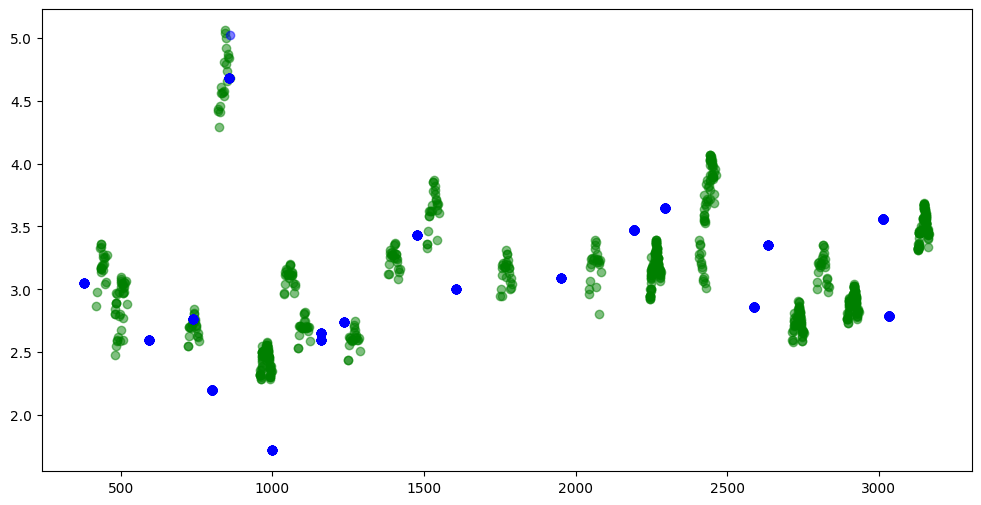

In [144]:
# Conventional plot of YTM to Seniority
plt.figure(figsize=(12, 6))
# make green bonds green, conventional blue
plt.scatter(df_k_prototypes[df_k_prototypes['Green_Bond_is_green'] == 1]['Green_Bond_Seniority'], df_k_prototypes[df_k_prototypes['Green_Bond_is_green'] == 1]['Green_Bond_YTM'], c='green', alpha=0.5)
plt.scatter(df_k_prototypes[df_k_prototypes['Conv_Bond_is_green'] == 0]['Conv_Bond_Seniority'], df_k_prototypes[df_k_prototypes['Conv_Bond_is_green'] == 0]['Conv_Bond_YTM'], c='blue', alpha=0.5)

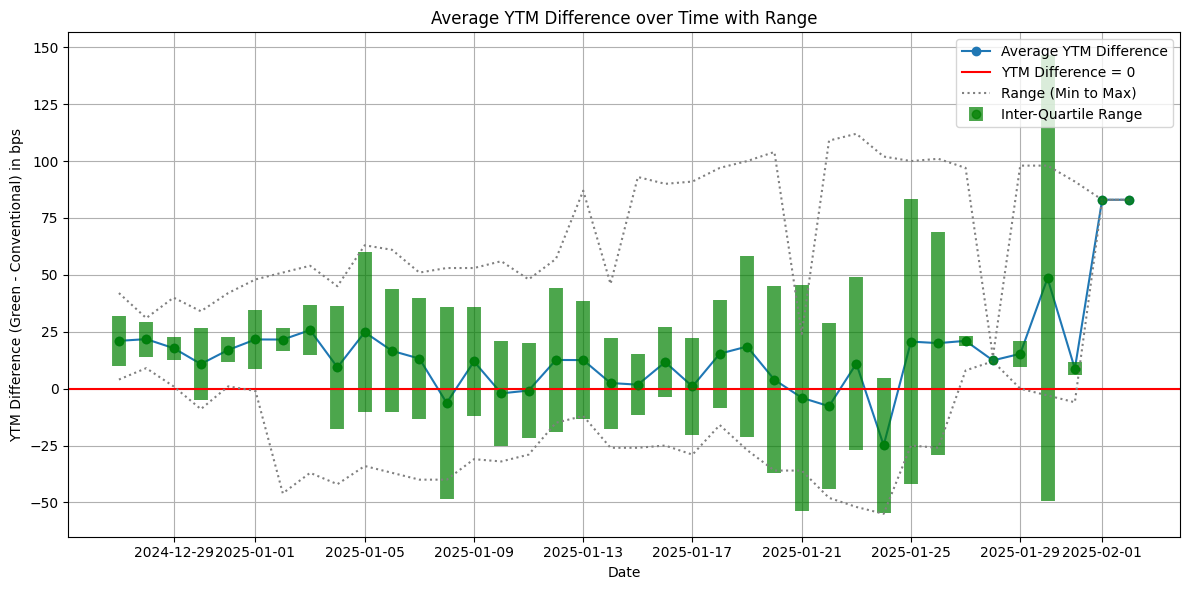

In [136]:
# Plot of YTM and Seniority as an overview
df_k_prototypes['Green_Bond_DateTime'] = pd.to_datetime(df_k_prototypes['Green_Bond_DateTime'])
df_k_prototypes['Conv_Bond_DateTime'] = pd.to_datetime(df_k_prototypes['Conv_Bond_DateTime'])
df_k_prototypes['pair_date'] = pd.to_datetime(
    (df_k_prototypes['Green_Bond_DateTime'].astype(np.int64) + df_k_prototypes['Conv_Bond_DateTime'].astype(np.int64)) // 2
)
df_k_prototypes['pair_date'] = df_k_prototypes['pair_date'].dt.date

# Calculating YTM_diff
df_k_prototypes['YTM_diff'] = df_k_prototypes['Green_Bond_YTM'] - df_k_prototypes['Conv_Bond_YTM']

# Group by the pair_date and calculate the average YTM difference for each day
daily_stats_k_prototype = df_k_prototypes.groupby('pair_date').agg(
	mean=('YTM_diff', 'mean'),
	min=('YTM_diff', 'min'),
	max=('YTM_diff', 'max'),
	quant75=('YTM_diff', lambda x: x.quantile(0.75)),
	quant25=('YTM_diff', lambda x: x.quantile(0.25))
).reset_index()
iqr = daily_stats_k_prototype['quant75'] - daily_stats_k_prototype['quant25']

# Convert pair_date back to datetime for plotting
daily_stats_k_prototype['pair_date'] = pd.to_datetime(daily_stats_k_prototype['pair_date'])

# Create the plot with mean and range
plt.figure(figsize=(12, 6))
plt.plot(daily_stats_k_prototype['pair_date'], daily_stats_k_prototype['mean'] * 100, marker='o', linestyle='-', label='Average YTM Difference')
plt.errorbar(daily_stats_k_prototype['pair_date'], daily_stats_k_prototype['min'] * 100, linestyle=':', color='grey', label='Range (Min to Max)', capsize=5)
plt.errorbar(daily_stats_k_prototype['pair_date'], daily_stats_k_prototype['max'] * 100, linestyle=':', color='grey')
# Add interquartile range (IQR) as a green box around the mean
plt.errorbar(daily_stats_k_prototype['pair_date'], daily_stats_k_prototype['mean'] * 100, yerr = iqr * 100, color='green', label='Inter-Quartile Range', alpha = 0.7, fmt='o', elinewidth=10, capthick=10)
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')
plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional) in bps')
plt.title('Average YTM Difference over Time with Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The matching method seems to affect our results considerably. we need to double check this. What is happening is that the matching method is ultimately doing a many-to-one matching where one conventional bonds matches with multiple green bonds and this dramitically affects our results. We also do not want this as were are throwing away a lot of data. This is to be fixed. we should only consider information from the same day, perferably within a two hour window to the green bond price data.

# 5 - Extended Panel Regression and Comparison Table

We do not reject the null hypothesis of is_green being equal to 0. Thus we cannot say that a significant greenium exists according to the panel regression. Note that we have strong autocorrelation in this setting. 

In [19]:
# Load required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels import PanelOLS

# load data again
# Read your CSV file
url = "https://raw.githubusercontent.com/Fijiman001/EGR-Empirical-Project/refs/heads/main/Econometrics/df_for_matching.csv"
df_for_matching = pd.read_csv(url)

# From before
# 2. Parse the 'Date' column (DD/MM/YYYY format) as datetime
df_panel = df_for_matching.copy()
df_panel['Date'] = pd.to_datetime(df_panel['Date'], format='%d/%m/%Y', errors='coerce')
df_panel['days_to_maturity'] = pd.to_numeric(df_panel['days_to_maturity'], errors='coerce')
df_panel['Coupon'] = pd.to_numeric(df_panel['Coupon'], errors='coerce')
df_panel['YTM'] = pd.to_numeric(df_panel['YTM'], errors='coerce')
# df_panel['Modified Duration'] = pd.to_numeric(df_panel['Modified Duration'], errors='coerce')
# df_panel.rename(columns={'Modified Duration': 'Modified_Duration'}, inplace=True)
#creating log of the emissions volume
df_panel['log_emissions_volume'] = np.log(df_panel['Emissionsvolumen'])

We include Macro variables, M_t:
Vix data: https://fred.stlouisfed.org/series/VIXCLS/
10 year Bund yield: https://www.marketwatch.com/investing/bond/tmbmkde-10y/download-data?countrycode=bx&mod=mw_quote_tab
3m euribor daily yields extracted from https://www.barchart.com/futures/quotes/IMM25/price-history/historical and https://www.global-rates.com/en/interest-rates/euribor/2/euribor-interest-3-months/

In [20]:
df_eurobor = pd.read_csv('Additional Data/cleaned_euribor_3month_data.csv')
df_bund_10yr = pd.read_csv('Additional Data/BOND_BX_XTUP_TMBMKDE-10Y.csv')
df_VIX = pd.read_csv('Additional Data/VIX.csv')
print(df_eurobor)
print(df_bund_10yr)
print(df_VIX)

          Date  Euribor_3m
0   2024-12-23       2.731
1   2024-12-24       2.719
2   2024-12-25       2.707
3   2024-12-26       2.695
4   2024-12-27       2.683
..         ...         ...
60  2025-03-17       2.456
61  2025-03-18       2.426
62  2025-03-19       2.411
63  2025-03-20       2.387
64  2025-03-21       2.386

[65 rows x 2 columns]
          Date   Open   High    Low  Close
0   03/21/2025  2.79%  2.79%  2.75%  2.77%
1   03/20/2025  2.81%  2.81%  2.75%  2.79%
2   03/19/2025  2.81%  2.82%  2.75%  2.81%
3   03/18/2025  2.83%  2.87%  2.81%  2.81%
4   03/17/2025  2.88%  2.90%  2.80%  2.83%
..         ...    ...    ...    ...    ...
73  12/06/2024  2.12%  2.13%  2.09%  2.11%
74  12/05/2024  2.06%  2.13%  2.05%  2.12%
75  12/04/2024  2.06%  2.11%  2.05%  2.06%
76  12/03/2024  2.04%  2.08%  2.03%  2.06%
77  12/02/2024  2.09%  2.09%  2.04%  2.04%

[78 rows x 5 columns]
     observation_date    VIX
0          20/03/2020  66.04
1          23/03/2020  61.59
2          24/03/2020  61.6

In [21]:
# merge dates after 20/12/2024 in VIX
df_eurobor["Date"] = pd.to_datetime(df_eurobor["Date"], errors="coerce")
df_bund_10yr["Date"] = pd.to_datetime(df_bund_10yr["Date"], format="%m/%d/%Y", errors="coerce")
df_VIX["observation_date"] = pd.to_datetime(df_VIX["observation_date"], errors="coerce")

# 2) Rename observation_date -> Date in df_VIX so we can merge on a common column
df_VIX.rename(columns={"observation_date": "Date"}, inplace=True)

# rename bund column close to Bund_10yr and discard the rest
df_bund_10yr = df_bund_10yr[["Date", "Close"]]
df_bund_10yr.rename(columns={"Close": "Bund_10yr"}, inplace=True)

# 3) Filter each DataFrame to keep only dates >= 2024-12-20
cutoff_date = pd.Timestamp("2024-12-20")
df_eurobor = df_eurobor[df_eurobor["Date"] >= cutoff_date]
df_bund_10yr = df_bund_10yr[df_bund_10yr["Date"] >= cutoff_date]
df_VIX = df_VIX[df_VIX["Date"] >= cutoff_date]

# 4) Merge all three DataFrames on Date.
#    how="inner" means only rows with matching dates in all three sets are kept.
df_additional_data = pd.merge(df_eurobor, df_bund_10yr, on="Date", how="inner")
df_additional_data = pd.merge(df_additional_data, df_VIX, on="Date", how="inner")
df_additional_data["Bund_10yr"] = df_additional_data["Bund_10yr"].str.replace("%", "", regex=False)
df_additional_data["Bund_10yr"] = pd.to_numeric(df_additional_data["Bund_10yr"], errors="coerce")

# replace any missing value with previous value
df_additional_data.fillna(method='ffill', inplace=True)
# renaming to fit panel data name
# df_additional_data.rename(columns={"Date": "pair_date"}, inplace=True)


# Inspect the final merged DataFrame
print(df_additional_data.head())
print("Number of rows in merged dataset:", len(df_additional_data))

        Date  Euribor_3m  Bund_10yr    VIX
0 2024-12-23     2.73100       2.32  16.78
1 2024-12-24     2.71900       2.32  14.27
2 2024-12-25     2.70700       2.32  14.27
3 2024-12-27     2.68300       2.40  15.95
4 2024-12-30     2.70625       2.37  17.40
Number of rows in merged dataset: 62


C:\Users\Alex\AppData\Local\Temp\ipykernel_13208\886768102.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_VIX["observation_date"] = pd.to_datetime(df_VIX["observation_date"], errors="coerce")
C:\Users\Alex\AppData\Local\Temp\ipykernel_13208\886768102.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_additional_data.fillna(method='ffill', inplace=True)


we merge this additional data with our panel data

In [22]:
#merging the additional data with the df_panel data
df_panel_merged = df_panel.merge(df_additional_data, on='Date', how='left')
# df_panel_merged = df_panel_merged.set_index(['ISIN'])
print(df_panel_merged.columns)
# we sort by ISIN and reset the index
df_panel_merged = df_panel_merged.sort_values('ISIN')
df_panel_merged = df_panel_merged.reset_index(drop=True)

Index(['Name', 'Clean_Company_Maturity', 'WKN', 'URL', 'ISIN', 'Company',
       'Kupon_Maturity', 'Coupon', 'Maturity_Start', 'Maturity_End',
       'is_green', 'last_price', 'DateTime', 'Volume.in.Euro', 'X.....',
       'Currency', 'YTM', 'modified_duration', 'Kupon', 'Emittent', 'Branche',
       'Fälligkeit', 'Schuldnerkündigungsart', 'Sonderkündigung', 'Nachrangig',
       'Kleinste.handelbare.Einheit', 'Spezialist', 'Handelsmodell',
       'Emissionsdatum', 'Emissionsvolumen', 'Umlaufendes.Volumen',
       'Emissionswährung', 'Depotwährung', 'Notierungsaufnahme',
       'Emission_year_2020.0', 'Emission_year_2021.0', 'Emission_year_2022.0',
       'Emission_year_2023.0', 'Emission_year_2024.0', 'Emission_year_2025.0',
       'Date', 'fälligkeit_datum', 'emission_datum', 'days_to_maturity',
       'maturity_years', 'log_emissions_volume', 'Euribor_3m', 'Bund_10yr',
       'VIX'],
      dtype='object')


In [23]:
# df_panel_merged.isna().sum()
# # we have some nas and drop them -> data collection was not good
# df_panel_merged.dropna(inplace=True)
print(df_panel_merged)

                                    Name             Clean_Company_Maturity  \
0     Mercedes-Benz Group AG 0,75% 20/30  mercedes benz group ag 0 75 20 30   
1     Mercedes-Benz Group AG 0,75% 20/30  mercedes benz group ag 0 75 20 30   
2     Mercedes-Benz Group AG 0,75% 20/30  mercedes benz group ag 0 75 20 30   
3     Mercedes-Benz Group AG 0,75% 20/30  mercedes benz group ag 0 75 20 30   
4     Mercedes-Benz Group AG 0,75% 20/30  mercedes benz group ag 0 75 20 30   
...                                  ...                                ...   
5943                  E.ON SE 3,5% 25/33                  e on se 3 5 25 33   
5944                  E.ON SE 3,5% 25/33                  e on se 3 5 25 33   
5945                  E.ON SE 3,5% 25/33                  e on se 3 5 25 33   
5946                  E.ON SE 3,5% 25/33                  e on se 3 5 25 33   
5947                  E.ON SE 3,5% 25/33                  e on se 3 5 25 33   

         WKN                                       

\noindent In addition to the matching method, we re‐estimate the panel regression with issuer‐level fixed effects to account for the unobserved heterogeneity present in our data set, and address time‐series dependence by using Newey–West derived standard errors. We also cluster standard errors at the issuer level, since price data within each issuer are likely to be correlated. By including issuer fixed effects, we control for all time‐invariant, issuer‐specific attributes, thereby mitigating concerns arising from missing credit‐rating data. Moreover, clustering the standard errors at the issuer level helps address potential serial correlation over time within each issuer’s series.

\subsection{Conceptual Setup}

A simplified version of the panel model can be written as:
\begin{equation}
\mathrm{YTM}_{i,t} \;=\; \alpha_i \;+\; \gamma_t \;+\; \beta \,\mathrm{GreenIndicator}_{i,t}
\;+\; X_{i,t}\,\delta \;+\; \varepsilon_{i,t},
\end{equation}
where \(i\) indexes issuers (or bonds), \(t\) indexes time (e.g.\ day, week, or month), \(\alpha_i\) denotes issuer fixed effects capturing all unobserved time‐invariant heterogeneity at the issuer level, \(\gamma_t\) is a time fixed effect (often included if there is a desire to remove common time shocks), \(\mathrm{GreenIndicator}_{i,t}\) is a dummy variable taking the value of 1 if the bond is green at time \(t\) and 0 otherwise, \(X_{i,t}\) represents a vector of additional controls (for instance, days to maturity, coupon, or modified duration), \(\beta\) is the coefficient of interest measuring the average difference in yield between green and conventional bonds conditional on the included controls, and \(\varepsilon_{i,t}\) is the error term clustered by issuer \(i\) to address serial correlation and heteroscedasticity.


Running the following Panel regressions:
$$ YTM = \alpha_i + \beta is\_ green_i + \gamma X_{it} + \delta M_t + \varepsilon_{it} $$
based upon Pietsch and Salakhova.
Cluster by bond to account for the seial correlation

In [24]:
# 1) Convert 'Date' to datetime and set a MultiIndex (Issuer, BondID, Date) or (Issuer, Date, BondID).
df_panel_merged["Date"] = pd.to_datetime(df_panel_merged["Date"], errors="coerce")

# For issuer-level FE, set the index to (Issuer, Date) so each issuer is an entity, observed over multiple dates.
df_panel_merged = df_panel_merged.set_index(["Company", "Date"]).sort_index()

# 2) Drop rows with missing values in the variables you plan to use
vars_needed = ["YTM", "is_green", "days_to_maturity", "modified_duration", "log_emissions_volume",
               "Coupon", "Euribor_3m", "Bund_10yr", "VIX", "ISIN"]
df_panel_merged.dropna(subset=vars_needed, inplace=True)

# 3) Fit the model with issuer-level (entity) fixed effects and cluster by BondID
#    so that standard errors account for correlation within each bond.
model_green = PanelOLS.from_formula(
    formula="YTM ~ is_green + days_to_maturity + modified_duration + log_emissions_volume +"
            "Coupon + Euribor_3m + Bund_10yr + VIX + EntityEffects",
    data=df_panel_merged
)
model_non_green = PanelOLS.from_formula(
    formula="YTM ~ days_to_maturity + modified_duration + log_emissions_volume +"
            "Coupon + Euribor_3m + Bund_10yr + VIX + EntityEffects",
    data=df_panel_merged
)

results_panel_extended = model_non_green.fit(
    cov_type='clustered',
    clusters=df_panel_merged["ISIN"],
    cluster_entity=False,
    cluster_time=False
)
results_panel_extended_green = model_green.fit(
    cov_type='clustered',
    clusters=df_panel_merged["ISIN"],
    cluster_entity=False,
    cluster_time=False
)

print(results_panel_extended.summary)
print(results_panel_extended_green.summary)
# Export to Latex as one table with both results
with open('panel_regression_results.tex', 'w') as f:
    f.write(results_panel_extended.summary.as_latex())
with open('panel_regression_results_green.tex', 'w') as f:
    f.write(results_panel_extended_green.summary.as_latex())

                          PanelOLS Estimation Summary                           
Dep. Variable:                    YTM   R-squared:                        0.6391
Estimator:                   PanelOLS   R-squared (Between):              0.8543
No. Observations:                5445   R-squared (Within):               0.6391
Date:                Tue, Mar 25 2025   R-squared (Overall):              0.8527
Time:                        11:13:22   Log-likelihood                    1416.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1367.9
Entities:                          32   P-value                           0.0000
Avg Obs:                       170.16   Distribution:                  F(7,5406)
Min Obs:                       1.0000                                           
Max Obs:                       797.00   F-statistic (robust):             172.66
                            